In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
 
from funciones import read_data, calcular_distancia, calcular_matriz_dist, calcular_largo_ruta, graficar_ruta
from instancia import ubis, cap_tpte, info_locales
from instancia import G, color_nodos, color_arcos, ancho_edges

random.seed(42)
np.random.seed(42)

<Figure size 360x360 with 0 Axes>

In [2]:
info_locales

,i,X,Y,I,U,L,r,h
0,0,444,237,1428,100000,0,-581,0.30
1,1,152,180,87,174,0,87,0.23
2,2,230,141,27,54,0,27,0.32
3,3,134,163,20,30,0,10,0.33
4,4,459,282,55,110,0,55,0.23
5,5,269,455,142,213,0,71,0.18
6,6,79,326,69,138,0,69,0.29
7,7,5,235,158,237,0,79,0.42
8,8,51,412,86,129,0,43,0.42
9,9,310,113,77,154,0,77,0.24


In [3]:
def reaccionar_inventario(G, tolerancia):
    """
    Función que verifica que locales deben ser visitados en base a su inventario actual. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    visitas = {nodo : False for nodo in G.nodes()}

    for nodo in G.nodes(data=True):
    
        if nodo[1]['Inv'] <= tolerancia * nodo[1]['Up']:
            visitas[nodo[0]] = True
    
    return visitas


visitas = reaccionar_inventario(G, 0.3)
for nodo in G.nodes(data=True):
    if nodo[0] != 'N_0':
        print(nodo[0], ": ", 100*nodo[1]['Inv']/nodo[1]['Up'], "%", visitas[nodo[0]])

# print(G.nodes(data=True))
print()
        

N_1 :  50.0 % False
N_2 :  50.0 % False
N_3 :  66.66666666666667 % False
N_4 :  50.0 % False
N_5 :  66.66666666666667 % False
N_6 :  50.0 % False
N_7 :  66.66666666666667 % False
N_8 :  66.66666666666667 % False
N_9 :  50.0 % False
N_10 :  66.66666666666667 % False



In [4]:
def IC_nrm(mu, sd, M=1000, alfa = 0.95):
    """
    Función que calcula el intervalo de confianza para una distribución normal.
    """
    from scipy.stats import norm
    limite_inferior = mu + norm.ppf((1 - alfa) / 2) * sd / math.sqrt(M)
    limite_superior = mu - norm.ppf((1 - alfa) / 2) * sd / math.sqrt(M)
    
    return limite_inferior, limite_superior

In [5]:
IC_nrm(10, 2, alfa = 0.95)

(9.876040993539087, 10.123959006460913)

In [6]:
def pronosticar_inventario(G, tolerancia, dist = 'n', mu = 0, sigma = 0.1, M = 1000):
    """
    Función que verifica que locales deben ser visitados en base a su inventario. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    visitas = {nodo : False for nodo in G.nodes()}

    for nodo in G.nodes(data=True):
        mean = nodo[1]['Prod'] + mu
        sd = nodo[1]['Prod'] * sigma
        l_inf, l_sup = IC_nrm(mean, sd, alfa = 0.95)
        pronostico = l_inf
        if nodo[1]['Inv'] - pronostico <= tolerancia * nodo[1]['Up']:
            visitas[nodo[0]] = True
    
    return visitas

In [7]:
for nodo in G.nodes(data=True):
    print(nodo[0],nodo[1]['Prod'])

N_0 -581
N_1 87
N_2 27
N_3 10
N_4 55
N_5 71
N_6 69
N_7 79
N_8 43
N_9 77
N_10 63


In [8]:
def simular_demanda_previa(G, dist = 'n',T =100, ruido = 0):
    """
    Función que simula la demanda previa de los locales.
    """
    demandas = {nodo : [] for nodo in G.nodes() if nodo != 'N_0'}
    # r = {nodo : nodo[1]['Prod'] for nodo in G.nodes(data=True)}
    if dist == 'n':
        for nodo in G.nodes(data=True):
            print(nodo[0],nodo[1]['Prod'])
            if nodo[0] != 'N_0':
                dem_pasadas = [max(
                    np.random.normal(loc = nodo[1]['Prod'], scale = nodo[1]['Prod'] * 0.05) 
                    + np.random.normal(loc = 0, scale = nodo[1]['Prod'] * ruido)
                    ,0) for _ in range(T)]
                demandas[nodo[0]] = dem_pasadas
         
    return demandas

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#graficar demanda historica
plt.figure(figsize=(10, 5))
for nodo in dem_historico.keys():
    if nodo != 'N_0':
        plt.plot(dem_historico[nodo])
        # plt.plot(smooth(dem_historico[nodo], 10))
plt.legend([nodo for nodo in dem_historico.keys() if nodo != 'N_0'])
plt.xlabel('Días')
plt.ylabel('Demanda')
plt.title('Demanda histórica')
plt.show()


NameError: name 'dem_historico' is not defined

<Figure size 720x360 with 0 Axes>

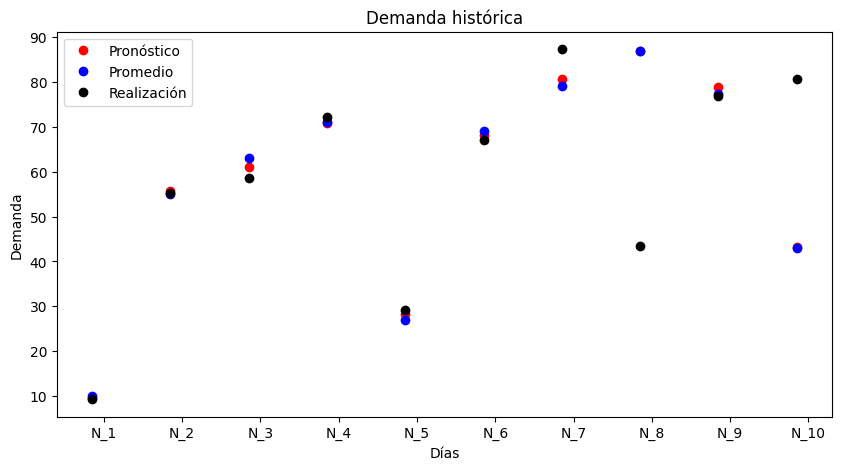

In [ ]:
dict = {'a': 1, 'b': 2, 'c': 3}
dict['a']

In [ ]:
def SEDA(datos, pron = False, alpha=0.1, beta=0.1, theta=0.5):
    '''
    Suavizamiento Exponencial Doble Amortiguado
    Aplica el método de suavizamiento exponencial doble a una serie de datos,
    específicmamente el Método de Holt Damped.
    '''
    I = [datos[0]]
    S = [datos[1]-datos[0]]
    for i in range(1,len(datos)):
        I.append(alpha*datos[i] + (1-alpha)*(I[i-1]+ theta*S[i-1]))
        S.append(beta*(I[i]-I[i-1])+(1-beta)*S[i-1])
    
    next = I[-1] + theta * S[-1]
    if pron:
        return next
    else:
        I.append(next)
        return I

muestra = True

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in set(dem_historico)-set(['N_0'])}
    data = {nodo: dem_historico[nodo][1:] for nodo in set(dem_historico)-set(['N_0'])}
    y = [SEDA(data[nodo], pron=True, alpha = 0.5) for nodo in set(data)]
    medias = [np.mean(data[nodo]) for nodo in set(data)]
    ind = np.arange(len(y))

    # y = [SEDA(dem_historico[nodo], pron=True, alpha = 0.5) for nodo in set(dem_historico)-set(['N_0'])]
    # medias = [np.mean(dem_historico[nodo]) for nodo in set(dem_historico)-set(['N_0'])]
    # ind = np.arange(len(y))
    
    # print(y)
    ancho = 0.3
    plt.figure(figsize=(10, 5))
    plt.plot(y, 'o', label='Pronóstico', color='red')
    plt.plot(medias, 'o', label='Promedio', color='blue')
    plt.plot(demanda.values(), 'o', label='Realización', color='black')
    # plt.bar(ind, y, width=ancho, label='Pronóstico', color='red')
    # plt.bar(ind + ancho, medias, width=ancho, label='Promedio', color='blue')
    plt.xticks(ind + ancho / 2, [f'N_{i}' for i in range(1,len(y)+1)])

    plt.xlabel('Días')
    plt.ylabel('Demanda')
    plt.title('Demanda histórica')
    plt.legend()
    plt.show()
print(demanda)
print(y[0])
# print(medias)

{'N_3': 9.327456039746272, 'N_4': 55.28579035017527, 'N_10': 58.5426612035714, 'N_5': 72.16780188403617, 'N_2': 29.083816370160065, 'N_6': 67.02162001773617, 'N_1': 87.24663035328884, 'N_8': 43.52730514707535, 'N_9': 76.82979113899923, 'N_7': 80.63663207637609}
9.569569386357804


In [ ]:
dict = {'a': 1, 'b': 2, 'c': 3}
for key in set(dict)-set('a'):
    print(key)

b
c


In [ ]:
def simular_ejecucion(grafo_inicial = G, T=600, ALNS=True):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 

    


simular_ejecucion(G)
        

[1428, 87, 27, 20, 55, 142, 69, 158, 86, 77, 126]


In [ ]:
G.nodes(data=True)['N_0']['Inv']

1428